In [3]:
from scipy.misc import imread, imsave, imresize
import matplotlib.pyplot as plt
import numpy as np
from random import randint
import time

# helpers, nothing interesting inside
from cs231nlib.utils import load_CIFAR10;
from cs231nlib.utils import visualize_CIFAR;

print("Hellow world")

Hellow world


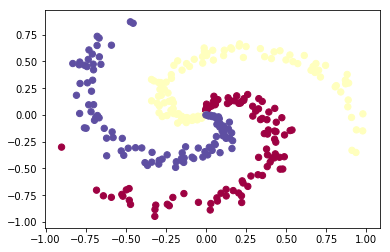

In [4]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [5]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(1):
  
  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b 
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
    
  print(dscores)    

  dscores /= num_examples

  
  print(num_examples)
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)

  print(db)
  print(X.T)
  print(dscores)
  
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.100306
[[-0.66666667  0.33333333  0.33333333]
 [-0.66668116  0.33334705  0.33333411]
 [-0.66667828  0.3333597   0.33331859]
 [-0.66667621  0.33337222  0.333304  ]
 [-0.66671803  0.33338789  0.33333014]
 [-0.66668401  0.33339827  0.33328574]
 [-0.66676251  0.333416    0.3333465 ]
 [-0.6667249   0.33342692  0.33329798]
 [-0.66684015  0.33344467  0.33339548]
 [-0.66690931  0.33345846  0.33345085]
 [-0.66674145  0.33346644  0.33327502]
 [-0.66703843  0.33348339  0.33355503]
 [-0.66705732  0.33349787  0.33355945]
 [-0.66698783  0.33351437  0.33347346]
 [-0.66704554  0.33352793  0.33351761]
 [-0.66704811  0.33354214  0.33350597]
 [-0.66716225  0.33355387  0.33360838]
 [-0.6674786   0.33353374  0.33394486]
 [-0.66703762  0.33358357  0.33345405]
 [-0.66756127  0.33356018  0.33400109]
 [-0.66758432  0.33357713  0.33400719]
 [-0.66752903  0.33360553  0.3339235 ]
 [-0.66773862  0.33358718  0.33415145]
 [-0.66787845  0.33356838  0.33431006]
 [-0.66793733  0.33357582  0.33436151

In [6]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.51


(-1.9478990560360834, 1.85210094396392)

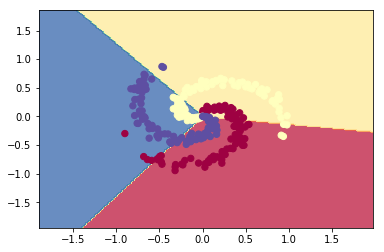

In [7]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

### Training a Neural Network

Now we have the gradient on the outputs of the hidden layer. Next, we have to backpropagate the ReLU non-linearity. This turns out to be easy because ReLU during the backward pass is effectively a switch. Since $r = max(0, x)$, we have that $\frac{dr}{dx} = 1(x > 0)$. Combined with the chain rule, we see that the ReLU unit lets the gradient pass through unchanged if its input was greater than 0, but kills it if its input was less than zero during the forward pass. Hence, we can backpropagate the ReLU in place simply with:

```
# backprop the ReLU non-linearity
dhidden[hidden_layer <= 0] = 0
```

In [8]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098698
iteration 1000: loss 0.324260
iteration 2000: loss 0.272277
iteration 3000: loss 0.257670
iteration 4000: loss 0.254690
iteration 5000: loss 0.253597
iteration 6000: loss 0.252731
iteration 7000: loss 0.251982
iteration 8000: loss 0.251169
iteration 9000: loss 0.250413


In [9]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.99


(-1.9478990560360834, 1.85210094396392)

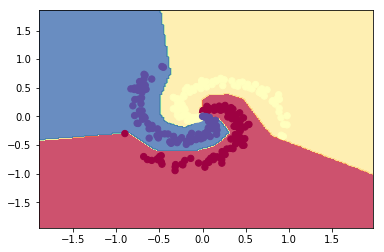

In [10]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())